# 第7章 実験条件の探索

## 7. 1 逆解析による条件探索

## 7. 2 応答局面法

ライブラリのインポート

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Google Driveのマウント

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/Cheminformatics")
print(os.getcwd())

/content/drive/MyDrive/Cheminformatics


データの読み込み

In [ ]:
df = pd.read_csv("doe.csv")
print(df.shape)
df

(9, 3)


,conc,temp,yield
0,0.1,10,5
1,0.1,30,30
2,0.1,40,15
3,0.5,10,20
4,0.5,30,55
5,0.5,40,40
6,1.0,10,52
7,1.0,30,30
8,1.0,40,15


目的変数と説明変数を分離

In [ ]:
X = df[["conc", "temp"]]
y = df["yield"]

説明変数の規格化

In [ ]:
min_conc, max_conc = np.min(df["conc"]), np.max(df["conc"])
min_temp, max_temp = np.min(df["temp"]), np.max(df["temp"])

X_normalized = (X - X.min())/(X.max() - X.min())
X_normalized

,conc,temp
0,0.000000,0.000000
1,0.000000,0.666667
2,0.000000,1.000000
3,0.444444,0.000000
4,0.444444,0.666667
5,0.444444,1.000000
6,1.000000,0.000000
7,1.000000,0.666667
8,1.000000,1.000000


線形回帰モデル

In [ ]:
from sklearn.linear_model import LinearRegression

mlr = LinearRegression()
mlr.fit(X_normalized, y)

LinearRegression()

係数の確認

In [ ]:
mlr.coef_

array([14.58196721,  0.71428571])

シンプルな線形回帰モデルの予測値を可視化

In [ ]:
xx, yy = np.meshgrid(np.arange(0.0, 1.0, 0.025), np.arange(0.0, 1.0, 0.025))
df_plot = pd.DataFrame([xx.reshape(1, -1)[0], yy.reshape(1, -1)[0]]).T
df_plot.columns = ["conc", "temp"]

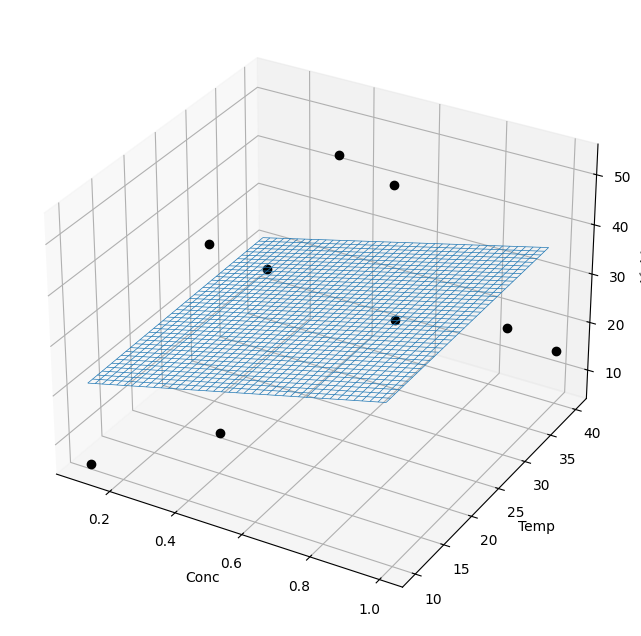

In [ ]:
zz = mlr.predict(df_plot)

# 可視化用に整形
xx_rescaled = xx*(max_conc - min_conc) + min_conc
yy_rescaled = yy*(max_temp - min_temp) + min_temp
zz = zz.reshape(xx.shape)

# 3Dで可視化を行う
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.plot_wireframe(xx_rescaled, yy_rescaled, zz, linewidth=0.5)
ax.plot(X["conc"], X["temp"], y, marker="o", color="black", linestyle="None")
ax.set_xlabel("Conc")
ax.set_ylabel("Temp")
ax.set_zlabel("Yield")
plt.show()

交互作用項の導入

In [ ]:
X["conc*temp"] = X["conc"] * X["temp"]
X["conc^2"] = X["conc"] ** 2
X["temp^2"] = X["temp"] ** 2
X

,conc,temp,conc*temp,conc^2,temp^2
0,0.1,10,1.0,0.01,100
1,0.1,30,3.0,0.01,900
2,0.1,40,4.0,0.01,1600
3,0.5,10,5.0,0.25,100
4,0.5,30,15.0,0.25,900
5,0.5,40,20.0,0.25,1600
6,1.0,10,10.0,1.00,100
7,1.0,30,30.0,1.00,900
8,1.0,40,40.0,1.00,1600


交互作用項も追加した重回帰モデルの作成

In [ ]:
X_normalized = (X - X.min())/(X.max() - X.min())

mlr_interact = LinearRegression()
mlr_interact.fit(X_normalized, y)
mlr_interact.coef_

array([ 135.38208431,  135.62138954,  -76.264637  ,  -72.78333333,
       -106.66666667])

交互作用項・二乗項を入れた線形回帰モデルの予測値を可視化

In [ ]:
df_plot["conc*temp"] = df_plot["conc"] * df_plot["temp"]
df_plot["conc^2"] = df_plot["conc"] ** 2
df_plot["temp^2"] = df_plot["temp"] ** 2

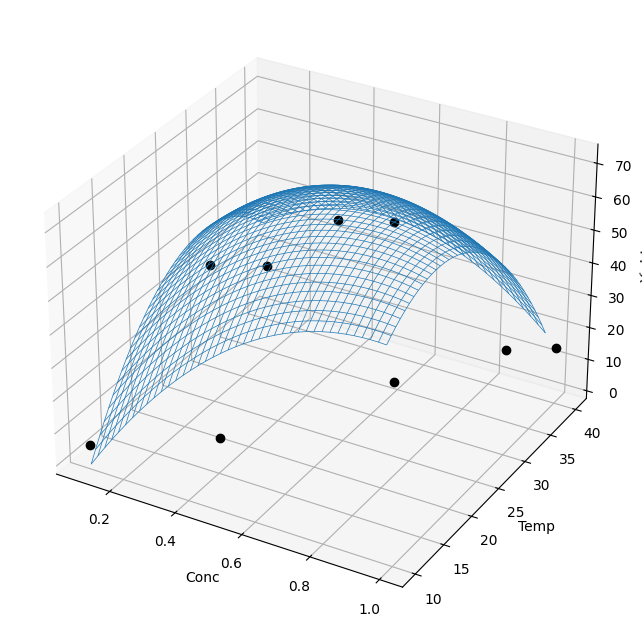

In [ ]:
zz = mlr_interact.predict(df_plot)
zz = zz.reshape(xx.shape)

# 3Dで可視化を行う
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.plot_wireframe(xx_rescaled, yy_rescaled, zz, linewidth=0.5)
ax.plot(X["conc"], X["temp"], y, marker="o", color="black", linestyle="None")
ax.set_xlabel("Conc")
ax.set_ylabel("Temp")
ax.set_zlabel("Yield")
plt.show()

### 7. 2. 1 ガウス過程回帰を用いたベイズ最適化

### 7. 2. 2 ガウス過程回帰

データの正規化

In [ ]:
X = df[["conc", "temp"]]
y = df["yield"]
X_normalized = (X - X.min())/(X.max() - X.min())
X_normalized

,conc,temp
0,0.000000,0.000000
1,0.000000,0.666667
2,0.000000,1.000000
3,0.444444,0.000000
4,0.444444,0.666667
5,0.444444,1.000000
6,1.000000,0.000000
7,1.000000,0.666667
8,1.000000,1.000000


カーネルの設定

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, DotProduct, WhiteKernel, RBF

kernel = 1 * RBF(0.15, length_scale_bounds=(1e-2, 1e+2))
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(X_normalized, y)

print(gpr.kernel_)
gpr.score(X_normalized, y)

28.6**2 * RBF(length_scale=0.532)


1.0

ガウス過程回帰モデルで予測した期待値の可視化

In [ ]:
# xx, yy = np.meshgrid(np.arange(0.0, 1.0, 0.025), np.arange(0.0, 1.0, 0.025))
df_plot = pd.DataFrame([xx.reshape(1, -1)[0], yy.reshape(1, -1)[0]]).T
df_plot.columns = ["conc", "temp"]

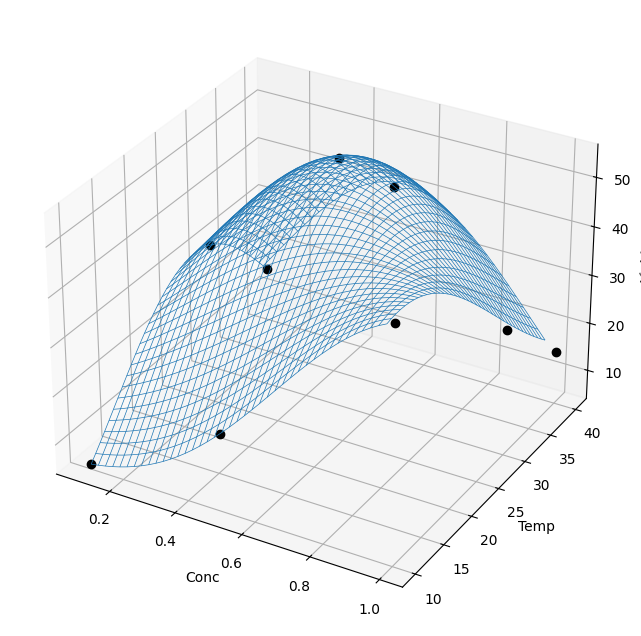

In [ ]:
zz = gpr.predict(df_plot, return_std=True)[0]
zz_upper = zz + 3*gpr.predict(df_plot, return_std=True)[1]
zz_lower = zz - 3*gpr.predict(df_plot, return_std=True)[1]


# 可視化用に整形
xx_rescaled = xx*(max_conc - min_conc) + min_conc
yy_rescaled = yy*(max_temp - min_temp) + min_temp
zz = zz.reshape(xx.shape)
zz_upper = zz_upper.reshape(xx.shape)
zz_lower = zz_lower.reshape(xx.shape)

# 3Dで可視化を行う
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.plot_wireframe(xx_rescaled, yy_rescaled, zz, linewidth=0.5)
ax.plot(X["conc"], X["temp"], y, marker="o", color="black", linestyle="None")
ax.set_xlabel("Conc")
ax.set_ylabel("Temp")
ax.set_zlabel("Yield")
plt.show()

ガウス過程回帰モデルで予測した期待値と分散の可視化

In [ ]:
zz = gpr.predict(df_plot, return_std=True)[0]
zz_upper = zz + 3*gpr.predict(df_plot, return_std=True)[1]
zz_lower = zz - 3*gpr.predict(df_plot, return_std=True)[1]

Best score: 55.58847695977631 (conc=0.5, temp=28.75)


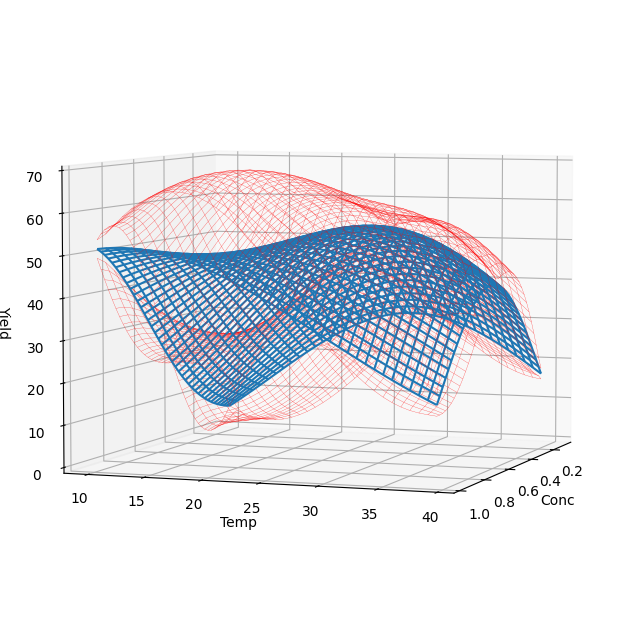

In [ ]:
# 可視化用に整形
zz = zz.reshape(xx.shape)
zz_upper = zz_upper.reshape(xx.shape)
zz_lower = zz_lower.reshape(xx.shape)

# ベストスコアの確認
print(f"Best score: {np.max(zz)} (conc={df_plot.iloc[np.argmax(zz), 0]}, temp={df_plot.iloc[np.argmax(zz), 1]*(max_temp - min_temp)+min_temp})")

# 3Dで可視化を行う
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.plot_wireframe(xx_rescaled, yy_rescaled, zz)
ax.plot_wireframe(xx_rescaled, yy_rescaled, zz_upper, color="red", linewidth=0.2, alpha=0.8)
ax.plot_wireframe(xx_rescaled, yy_rescaled, zz_lower, color="red", linewidth=0.2, alpha=0.8)

ax.view_init(elev=5, azim=20)
ax.set_xlabel("Conc")
ax.set_ylabel("Temp")
ax.set_zlabel("Yield")
plt.show()

### 7. 2. 3 ベイズ最適化

Upper Confidence Bound (UCB)で推測された条件を調べる

In [ ]:
print(f"Best a_ucb: {np.max(zz_upper)}\
 (conc={df_plot.iloc[np.argmax(zz_upper), 0]},\
 temp={df_plot.iloc[np.argmax(zz_upper), 1]*(max_temp - min_temp)+min_temp})")

Best a_ucb: 69.55374453575635 (conc=0.75, temp=19.75)


可視化の準備

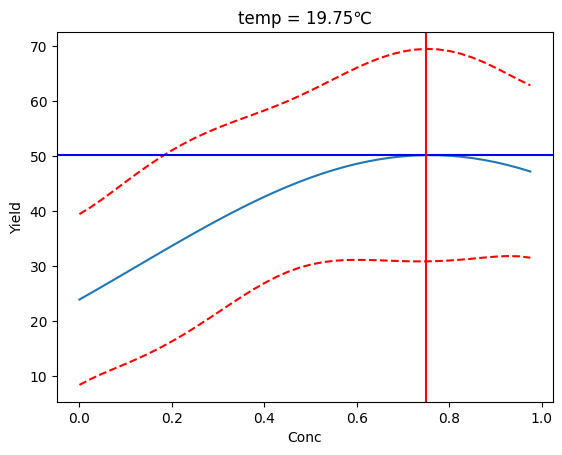

In [ ]:
x_2d = np.arange(0.0, 1.0, 0.025)
df_2dplot = pd.DataFrame([x_2d.reshape(1, -1)[0]]).T
df_2dplot.columns = ["conc"]
df_2dplot["temp"] = (19.75 - min_temp)/(max_temp - min_temp)

z_2d = gpr.predict(df_2dplot, return_std=True)[0]
z_2d_upper = z_2d + 3*gpr.predict(df_2dplot, return_std=True)[1]
z_2d_lower = z_2d - 3*gpr.predict(df_2dplot, return_std=True)[1]

plt.plot(x_2d, z_2d)
plt.plot(x_2d, z_2d_upper, color="red", ls="--")
plt.plot(x_2d, z_2d_lower, color="red", ls="--")
plt.title("temp = 19.75℃")
plt.xlabel("Conc")
plt.ylabel("Yield")

# best
plt.axhline(y=np.max(z_2d), color="blue")
plt.axvline(x=x_2d[np.argmax(z_2d_upper)], color="red")
plt.show()

### 7. 2. 4 ハイパーパラメータの最適化